# Importing libraries

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from sklearn.manifold import TSNE
from collections import Counter

### Description of Random Projection LSH Code

This code snippet implements the random projection Locality Sensitive Hashing (LSH) technique. Let's describe it mathematically with respect to LSH:

1. **Random Projection Matrix \( R \)**:
   - \( R \) is a \( d \times P \) matrix, where \( d \) is the dimensionality of the data and \( P \) is the number of hyperplanes.
   - Each entry \( r_{ij} \) in the matrix \( R \) is a random value drawn from a standard normal distribution.

2. **Hashing**:
   - Given a dataset \( X \) with \( n \) data points and \( d \) dimensions, we apply LSH by computing the hash values for each data point.
   - The hash values are computed by taking the sign of the dot product of each data point with the random projection matrix \( R \).
   - Let \( H \) be the resulting hash matrix of dimensions \( n \times P \), where each row represents the hash values for a data point and each column represents a hash function.
   - Mathematically, the hash values \( H \) are computed as follows:
     \[ H_{ij} = \text{sign}(\sum_{k=1}^{d} X_{ik} \times R_{kj}) \]
   - Where:
     - \( H_{ij} \) is the hash value of data point \( i \) using hash function \( j \).
     - \( X_{ik} \) is the \( k \)-th component of data point \( i \).
     - \( R_{kj} \) is the \( (k, j) \)-th component of the random projection matrix \( R \).
     - \( \text{sign}(x) \) is the sign function, which returns \( +1 \) if \( x > 0 \), \( -1 \) if \( x < 0 \), and \( 0 \) if \( x = 0 \).

3. **Output**:
   - The function returns the hash matrix \( H \) and the random projection matrix \( R \).
   - The hash matrix \( H \) is used for partitioning the data points into buckets based on their hash values, enabling efficient nearest neighbor search in LSH.


In [255]:
def random_projection_lsh(X, P=3):
    R = np.random.randn(X.shape[1], P)
    hashes = np.sign(X @ R)
    return hashes, R

In [256]:
def plot_hyperplanes(ax, hyperplanes):
    """
    Plots the decision boundaries of the hyperplanes.

    Args:
        ax: A matplotlib axis object.
        hyperplanes: A NumPy array representing the hyperplanes (shape: num_dimensions x num_hyperplanes).
    """
    num_hyperplanes = hyperplanes.shape[1]  # Number of hyperplanes

    for i in range(num_hyperplanes):
        # Check if all rows have non-zero values (avoid division by zero)
        if np.all(hyperplanes[:, i] != 0):
            slope = -hyperplanes[0, i] / hyperplanes[1, i]
            intercept = -hyperplanes[1, i] / hyperplanes[0, i]  # Adjust index for intercept
            x_vals = np.linspace(0, 1, 100)
            y_vals = slope * x_vals + intercept
            ax.plot(x_vals, y_vals, '--', label=f'Hyperplane {i+1}')
        else:
            print(f"Skipping hyperplane {i+1} due to zero coefficients.")


In [257]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time
# from memory_profiler import memory_usage


def lsh_nearest_neighbors(test_point, X_train, hyperplanes, d=2, num_buckets=8, num_trials=3):
    # Transpose test_point if necessary
    if test_point.ndim == 1:
        test_point = test_point.reshape(1, -1)  # Reshape to row vector
    elif test_point.shape[0] == 1:
        test_point = test_point.T  # Transpose to column vector

    # Initialize a list to store potential nearest neighbors
    all_potential_neighbors = []

    # Repeat the process for a definite number of trials
    for _ in range(num_trials):
        # Find the region (bucket) in which the test point lies
        hashes, hyperplanes = random_projection_lsh(X_train, P=3)
        k = hyperplanes.shape[1]
        plot_hyperplanes(plt, hyperplanes)  # Call your hyperplane plotting function
        plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)
        plt.scatter(test_point[0], test_point[1], c='red', label='Test Point', marker='o', s=80)
        plt.show()
        sgn = np.sign(test_point.T @ hyperplanes) > 0
        sgn = sgn[0]
        region = tuple(sgn)  # Convert signs to a hashable tuple
        # Convert the binary tuple into an integer index
        bucket_index = sum(2**i * int(b_) for i, b_ in enumerate(region[::-1]))
        # Initialize a list to store potential nearest neighbors for this trial
        potential_neighbors = []

        # Iterate through the training data and compare with test_point
        for i, x_train in enumerate(X_train):
            # Find the region (bucket) of the training point
            train_region = tuple(np.sign(x_train @ hyperplanes) > 0)
            train_bucket_index = sum(2**i * int(b) for i, b in enumerate(train_region[::-1]))

            # Check if the training point falls in the same bucket as the test point
            if train_bucket_index == bucket_index:
                potential_neighbors.append(x_train.tolist())  # Convert array to list before appending

        # Add the potential neighbors for this trial to the list
        all_potential_neighbors.extend(potential_neighbors)

    # Count the occurrences of each potential neighbor (using list as key)
    neighbor_counts = {}

    # Create a set of unique neighbors (tuples for hashability)
    unique_neighbors = set()
    for neighbor in all_potential_neighbors:
        # Convert neighbor to a tuple for hashability
        unique_neighbor_tuple = tuple(neighbor)
        unique_neighbors.add(unique_neighbor_tuple)

    # Loop through each unique neighbor and count its occurrences
    neighbor_counts = {}  # Dictionary to store neighbor counts
    for neighbor in unique_neighbors:
        # Count the number of times the current neighbor appears in all_potential_neighbors
        count = sum(1 for n in all_potential_neighbors if np.array_equal(np.array(neighbor), np.array(n)))

        # Add the neighbor and its count to the dictionary
        neighbor_counts[neighbor] = count

    # Filter potential neighbors that occur more than once
    potential_neighbors = [np.array(neighbor).tolist() for neighbor in unique_neighbors if neighbor_counts[neighbor] > 2]

    return potential_neighbors


In [268]:
Memory=[]
Memory_n=[]
Time_d=[]
Time_n=[]

# 5 Nearest Neighbors for N =100 and d= 2

Top 5 nearest neighbors: [(0.48857240292022086, 0.328182102100147), (0.4961833634397115, 0.3556120230723242), (0.398774672453989, 0.21688926050168444), (0.543825783022527, 0.16205105427399313), (0.4664343058453855, 0.1379512398772753)]


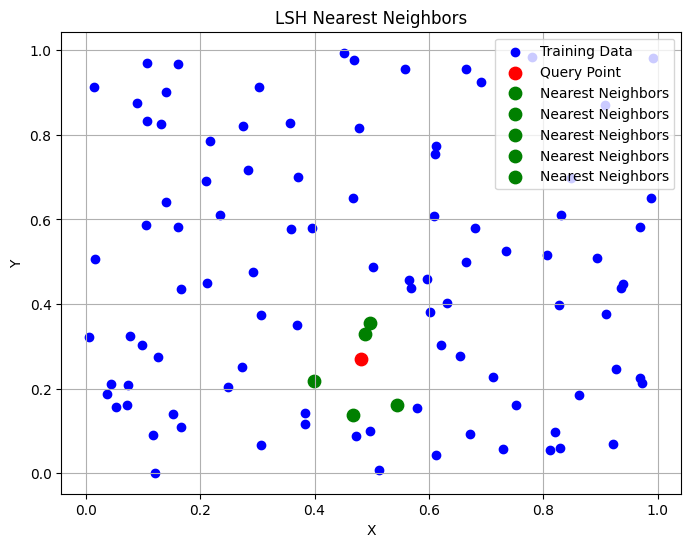

In [278]:
import numpy as np
import heapq

def lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=5, num_buckets=8, num_trials=3):
    # Initialize a dictionary to store potential neighbors
    potential_neighbors = {}

    # Perform LSH to retrieve potential neighbors
    for _ in range(num_trials):
        hashes, _ = random_projection_lsh(X_train, P=3)
        sgn = np.sign(query_point @ hyperplanes) > 0
        region = tuple(sgn[0])  # Convert signs to a hashable tuple
        bucket_index = sum(2**i * int(b) for i, b in enumerate(region[::-1]))

        # Retrieve potential neighbors from the corresponding bucket
        bucket_neighbors = potential_neighbors.get(bucket_index, [])
        bucket_neighbors.extend(X_train)
        potential_neighbors[bucket_index] = bucket_neighbors

    # Calculate distances between query point and potential neighbors
    distances = {}
    for bucket_index, neighbors in potential_neighbors.items():
        for neighbor in neighbors:
            distance = np.linalg.norm(query_point - neighbor)
            distances[tuple(neighbor)] = distance

    # Select top k nearest neighbors
    top_k_neighbors = heapq.nsmallest(k, distances, key=distances.get)

    return top_k_neighbors

# Example usage:
X_train = np.random.rand(100, 2)  # Example training data
query_point = np.random.rand(1, 2)  # Example query point
hashes, hyperplanes = random_projection_lsh(X_train, P=3)  # Generate hashes and hyperplanes

# Find top 5 nearest neighbors
k = 5
nearest_neighbors = lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=k)

print("Top", k, "nearest neighbors:", nearest_neighbors)
# Plotting
plt.figure(figsize=(8, 6))

# Plot training data
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data')

# Plot query point
plt.scatter(query_point[0, 0], query_point[0, 1], c='red', label='Query Point', marker='o', s=80)

# Plot nearest neighbors
for neighbor in nearest_neighbors:
    plt.scatter(neighbor[0], neighbor[1], c='green', label='Nearest Neighbors', marker='o', s=80)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# 5 Nearest Neighbors for N =100 and d= 10

Top 5 nearest neighbors: [(0.28103462553364233, 0.5440871776777428, 0.9039751701453678, 0.6793827758091265, 0.8117008508614699, 0.5889598960528658, 0.43281058282814533, 0.6871881110898844, 0.8108340760359307, 0.5133022155504315), (0.6454441691590823, 0.5544948414824145, 0.3968895209172968, 0.9119857609127481, 0.6896701093654237, 0.3782853722824463, 0.6051188512367149, 0.7320299813301013, 0.5361305283840812, 0.34422108754038105), (0.6375004506290094, 0.20733540547276286, 0.4709438603732802, 0.6684511370619559, 0.4864667410343191, 0.2818500558895729, 0.08393836884715433, 0.40843119388348004, 0.7028888090811996, 0.7921737027770115), (0.8352895696672528, 0.09591778825673358, 0.7813335439307743, 0.8472114856476737, 0.9362958464674064, 0.7312947367276261, 0.49537463820484695, 0.7663476651127312, 0.776129910561647, 0.2352923212472673), (0.3276384851123868, 0.6922238331764956, 0.8306036116856295, 0.6644211136833261, 0.39998462139029745, 0.22449404169146725, 0.13142668922052747, 0.8563804598138

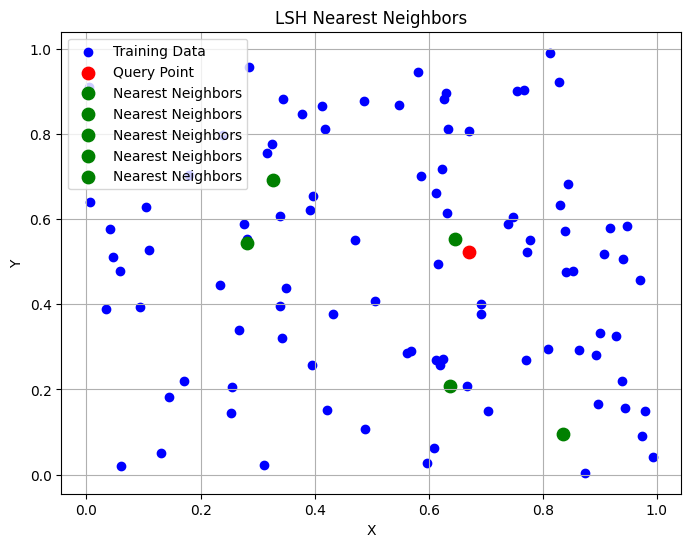

In [285]:
import numpy as np
import heapq

def lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=5, num_buckets=8, num_trials=3):
    # Initialize a dictionary to store potential neighbors
    potential_neighbors = {}

    # Perform LSH to retrieve potential neighbors
    for _ in range(num_trials):
        hashes, _ = random_projection_lsh(X_train, P=3)
        sgn = np.sign(query_point @ hyperplanes) > 0
        region = tuple(sgn[0])  # Convert signs to a hashable tuple
        bucket_index = sum(2**i * int(b) for i, b in enumerate(region[::-1]))

        # Retrieve potential neighbors from the corresponding bucket
        bucket_neighbors = potential_neighbors.get(bucket_index, [])
        bucket_neighbors.extend(X_train)
        potential_neighbors[bucket_index] = bucket_neighbors

    # Calculate distances between query point and potential neighbors
    distances = {}
    for bucket_index, neighbors in potential_neighbors.items():
        for neighbor in neighbors:
            distance = np.linalg.norm(query_point - neighbor)
            distances[tuple(neighbor)] = distance

    # Select top k nearest neighbors
    top_k_neighbors = heapq.nsmallest(k, distances, key=distances.get)

    return top_k_neighbors

# Example usage:
X_train = np.random.rand(100, 10)  # Example training data
query_point = np.random.rand(1, 10)  # Example query point
hashes, hyperplanes = random_projection_lsh(X_train, P=3)  # Generate hashes and hyperplanes

# Find top 5 nearest neighbors
k = 5
nearest_neighbors = lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=k)

print("Top", k, "nearest neighbors:", nearest_neighbors)
# Plotting
plt.figure(figsize=(8, 6))

# Plot training data
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data')

# Plot query point
plt.scatter(query_point[0, 0], query_point[0, 1], c='red', label='Query Point', marker='o', s=80)

# Plot nearest neighbors
for neighbor in nearest_neighbors:
    plt.scatter(neighbor[0], neighbor[1], c='green', label='Nearest Neighbors', marker='o', s=80)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# 5 Nearest Neighbors for N =1000 and d= 2

Top 5 nearest neighbors: [(0.35179009629973923, 0.8135508596802671), (0.35814208453407703, 0.8252888110571592), (0.35155938534107445, 0.7804437293414993), (0.3224124552907225, 0.806178105332558), (0.3241015989191157, 0.820916069423054)]


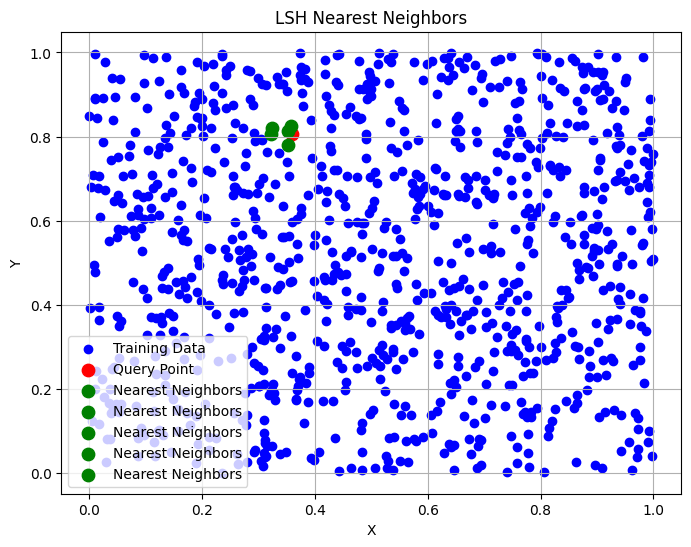

In [286]:
import numpy as np
import heapq

def lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=5, num_buckets=8, num_trials=3):
    # Initialize a dictionary to store potential neighbors
    potential_neighbors = {}

    # Perform LSH to retrieve potential neighbors
    for _ in range(num_trials):
        hashes, _ = random_projection_lsh(X_train, P=3)
        sgn = np.sign(query_point @ hyperplanes) > 0
        region = tuple(sgn[0])  # Convert signs to a hashable tuple
        bucket_index = sum(2**i * int(b) for i, b in enumerate(region[::-1]))

        # Retrieve potential neighbors from the corresponding bucket
        bucket_neighbors = potential_neighbors.get(bucket_index, [])
        bucket_neighbors.extend(X_train)
        potential_neighbors[bucket_index] = bucket_neighbors

    # Calculate distances between query point and potential neighbors
    distances = {}
    for bucket_index, neighbors in potential_neighbors.items():
        for neighbor in neighbors:
            distance = np.linalg.norm(query_point - neighbor)
            distances[tuple(neighbor)] = distance

    # Select top k nearest neighbors
    top_k_neighbors = heapq.nsmallest(k, distances, key=distances.get)

    return top_k_neighbors

# Example usage:
X_train = np.random.rand(1000, 2)  # Example training data
query_point = np.random.rand(1, 2)  # Example query point
hashes, hyperplanes = random_projection_lsh(X_train, P=3)  # Generate hashes and hyperplanes

# Find top 5 nearest neighbors
k = 5
nearest_neighbors = lsh_nearest_neighbors(query_point, X_train, hyperplanes, k=k)

print("Top", k, "nearest neighbors:", nearest_neighbors)
# Plotting
plt.figure(figsize=(8, 6))

# Plot training data
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data')

# Plot query point
plt.scatter(query_point[0, 0], query_point[0, 1], c='red', label='Query Point', marker='o', s=80)

# Plot nearest neighbors
for neighbor in nearest_neighbors:
    plt.scatter(neighbor[0], neighbor[1], c='green', label='Nearest Neighbors', marker='o', s=80)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()

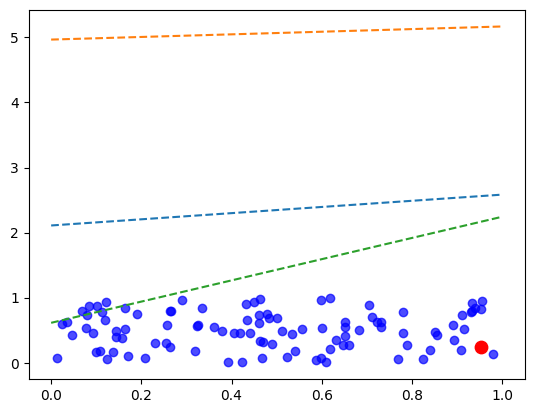

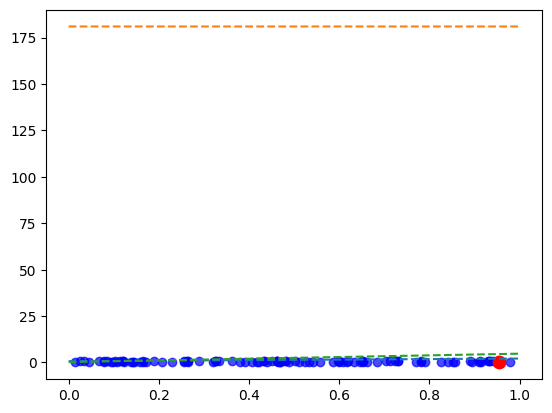

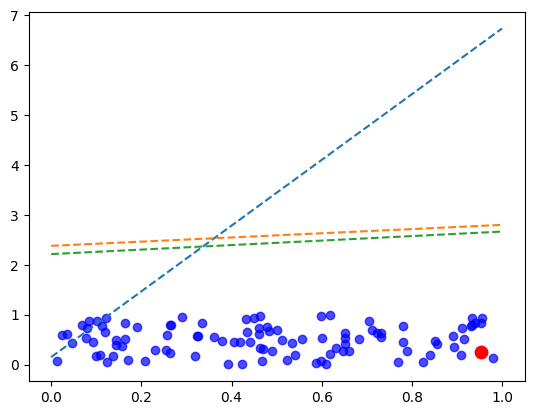

Memory Usage (bytes): 120


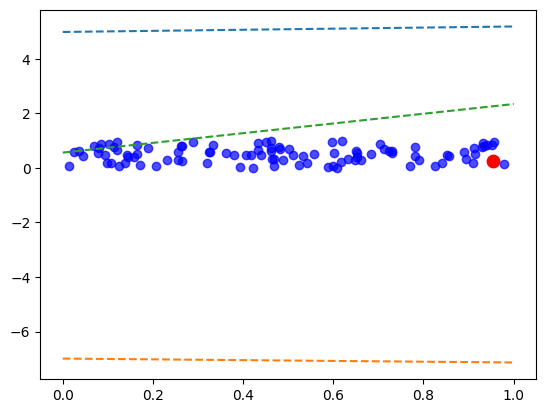

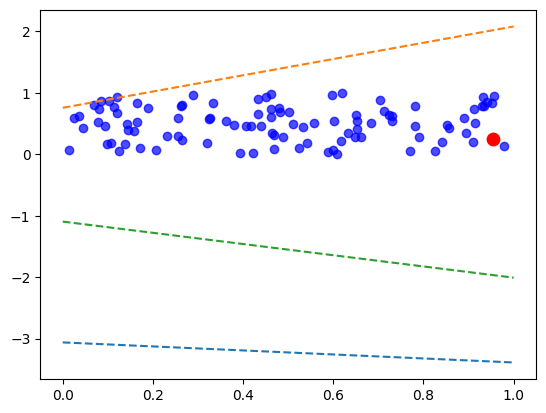

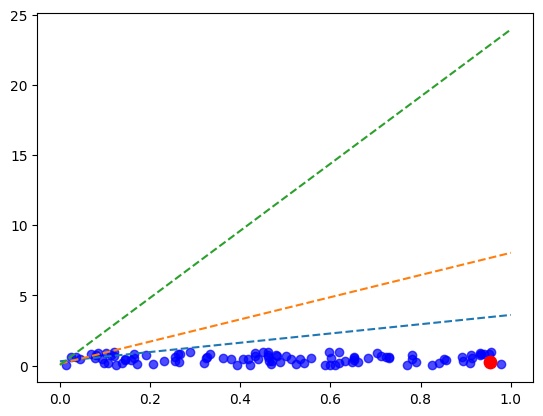

Repeated Neighbors: [[0.12362638658694058, 0.055292798777345276], [0.533303927704023, 0.4384618604720988], [0.6522477967414216, 0.5432367574280826], [0.3789733933638605, 0.4812156067826503], [0.8518260282013824, 0.470156105107585], [0.8559686477470513, 0.42296459760167004], [0.4180067869007491, 0.4587994871167306], [0.9322768543966603, 0.9253218200787091], [0.9556607683066305, 0.9445130067171903], [0.6512097494295047, 0.630538422950284], [0.6471268433295934, 0.27243929135138534], [0.4635645845951607, 0.3379889229297883], [0.6005395609536982, 0.5351318777685248], [0.40620819254404406, 0.457105459580737], [0.557257609284785, 0.513946140790877], [0.2639036778337712, 0.23608660232427858], [0.7304873378981265, 0.5476662951811183], [0.7804706322520222, 0.4543419742552266], [0.9150451541488908, 0.5116357440384864], [0.541842210914313, 0.18808415371700127], [0.940697129752618, 0.8420000918728673], [0.6327214587797346, 0.3428897789877995], [0.6179461625821641, 0.2092697815003206], [0.1374817375

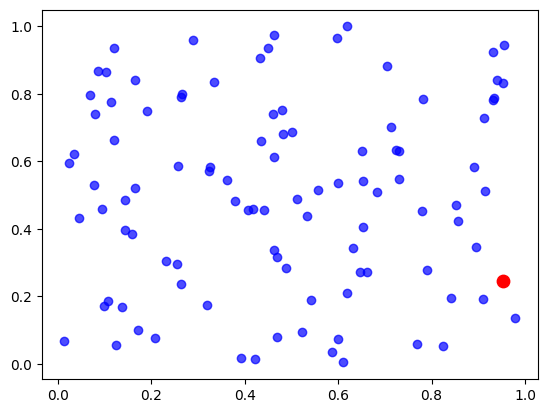

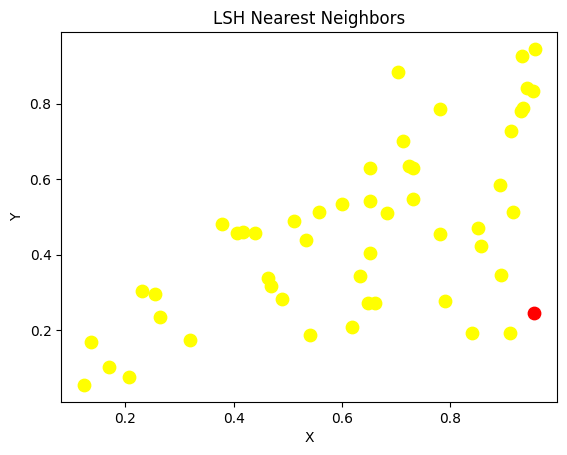

In [269]:
# Example usage:
X_train = np.random.rand(100, 2)  # Example training data
test_point = np.random.rand(1, 2)  # Example test point
hashes, hyperplanes = random_projection_lsh(X_train, P=2)  # Generate hashes and hyperplanes

import sys

# Measure memory usage
mem_usage = sys.getsizeof(lsh_nearest_neighbors(test_point, X_train, hyperplanes))

print("Memory Usage (bytes):", mem_usage)

Memory.append(mem_usage)
Memory_n.append(mem_usage)
# Measure execution time
start_time = time.time()
potential_neighbors = lsh_nearest_neighbors(test_point, X_train, hyperplanes)
end_time = time.time()
execution_time = end_time - start_time

print("Repeated Neighbors:", potential_neighbors)
# print("Memory Usage (MB):", max(mem_usage))
print("Execution Time (seconds):", execution_time)

Time_d.append(execution_time)
Time_n.append(execution_time)
# Plot training data (blue)
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
plt.show()

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
# Plot nearest neighbors (yellow)
for neighbor in potential_neighbors:
  plt.scatter(neighbor[0], neighbor[1], c='yellow', label='Nearest neighbors', marker='o', s=80)

# Add legend and labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.show()

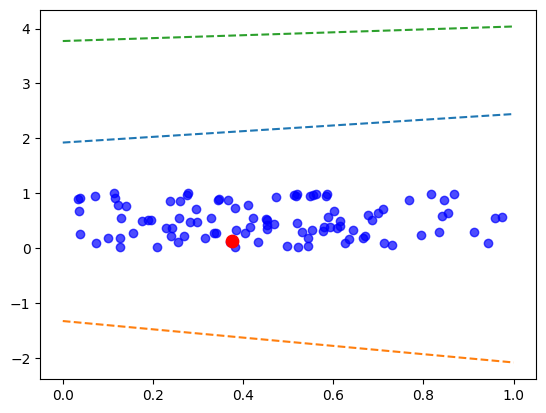

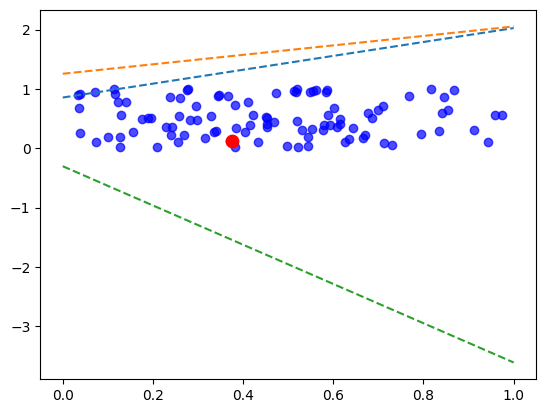

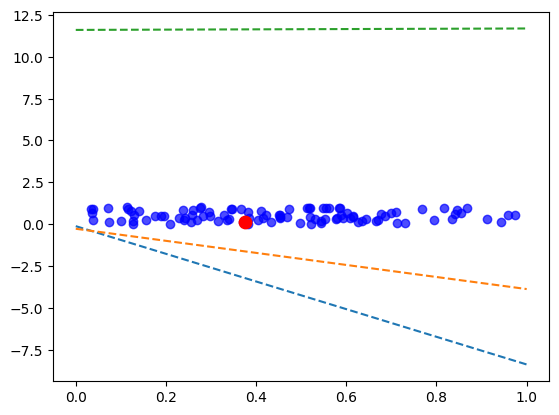

Memory Usage (bytes): 472


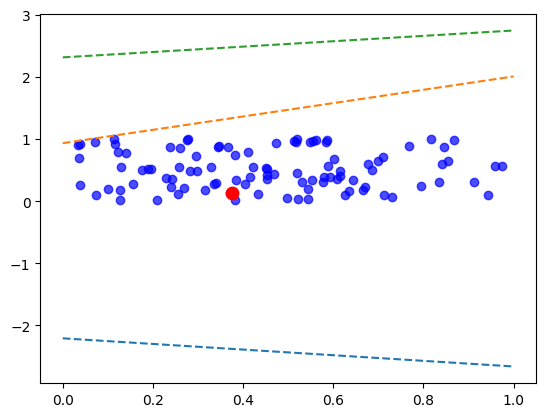

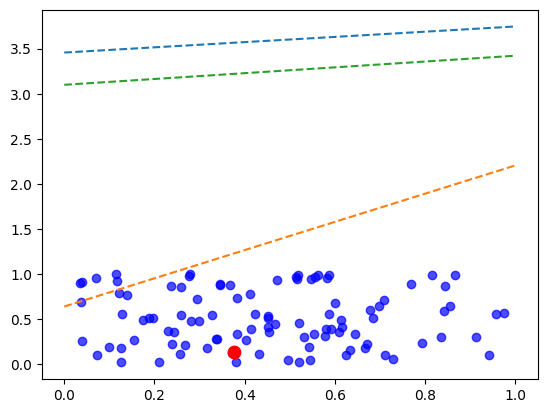

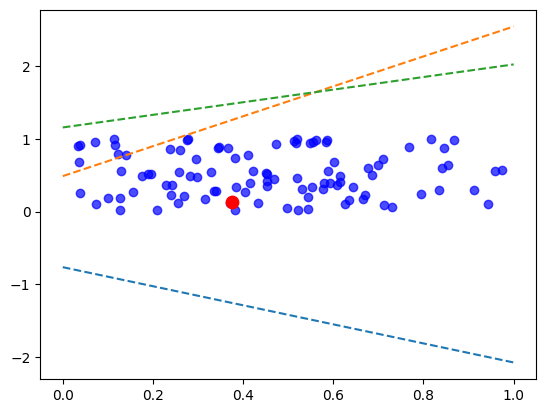

Repeated Neighbors: [[0.12619602575338074, 0.18420573119647798, 0.8458848927987676, 0.8127675476369065, 0.6663889693410735, 0.6551688941392925, 0.7462550380183504, 0.550436124190608, 0.6162615495867244, 0.5257191693156288], [0.5831618204803153, 0.950153674686572, 0.7633578594444249, 0.17533469061743523, 0.3289598681107424, 0.8504018682612023, 0.602454755539357, 0.5047890743154563, 0.8995026701038336, 0.9948122999754441], [0.18826200688238448, 0.5091723031393871, 0.5434861808591258, 0.8892472161338464, 0.0016715445660023809, 0.9579301036157031, 0.9425723241745265, 0.32680942814711744, 0.5703140580005774, 0.977638356988994], [0.2372911952789719, 0.8653315193693113, 0.6476230488709871, 0.10432677376305544, 0.022594623807203784, 0.8157433642134398, 0.6591099980789396, 0.6440522846433171, 0.7116236375374797, 0.33618013745057074], [0.6848218908819527, 0.5074797072964847, 0.40322201048776407, 0.7923333294087764, 0.26554186364606014, 0.7110922717528452, 0.3141144034882545, 0.9531574795840485, 

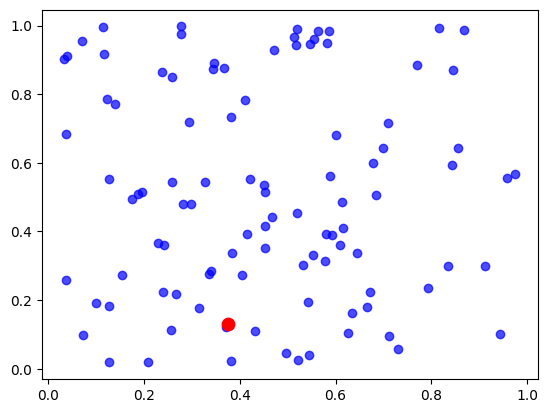

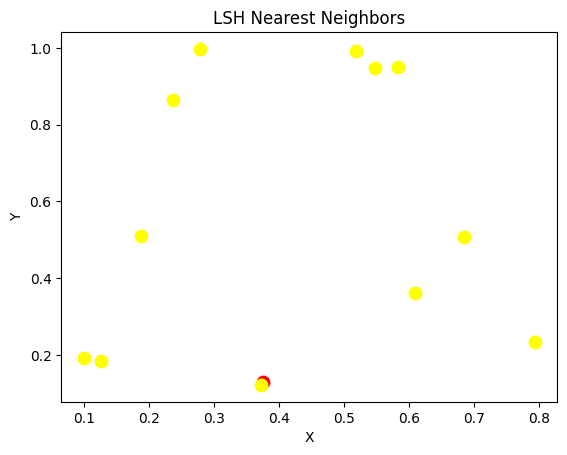

In [260]:
# Example usage:
X_train = np.random.rand(100, 10)  # Example training data
test_point = np.random.rand(1, 10)  # Example test point
hashes, hyperplanes = random_projection_lsh(X_train, P=2)  # Generate hashes and hyperplanes

import sys

# Measure memory usage
mem_usage = sys.getsizeof(lsh_nearest_neighbors(test_point, X_train, hyperplanes))

print("Memory Usage (bytes):", mem_usage)

Memory.append(mem_usage)

# Measure execution time
start_time = time.time()
potential_neighbors = lsh_nearest_neighbors(test_point, X_train, hyperplanes)
end_time = time.time()
execution_time = end_time - start_time

print("Repeated Neighbors:", potential_neighbors)
# print("Memory Usage (MB):", max(mem_usage))
print("Execution Time (seconds):", execution_time)
Time_d.append(execution_time)


# Plot training data (blue)
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
plt.show()

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
# Plot nearest neighbors (yellow)
for neighbor in potential_neighbors:
  plt.scatter(neighbor[0], neighbor[1], c='yellow', label='Nearest neighbors', marker='o', s=80)

# Add legend and labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.show()

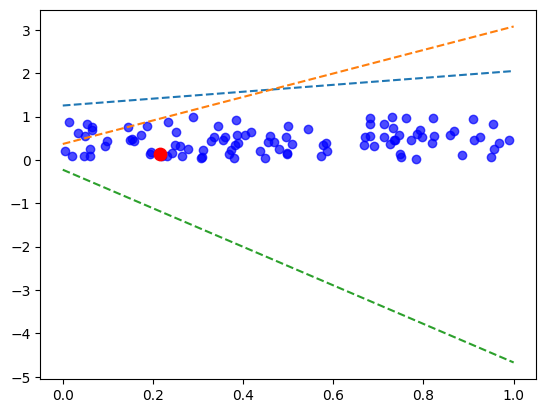

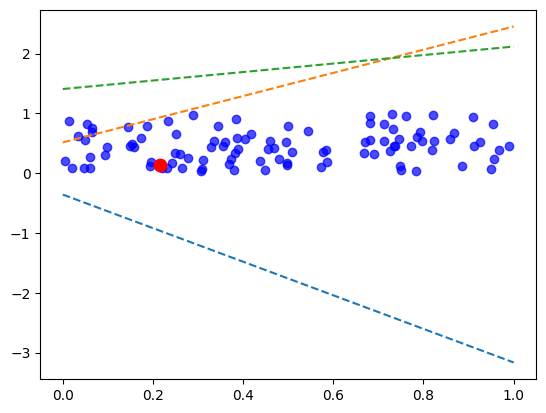

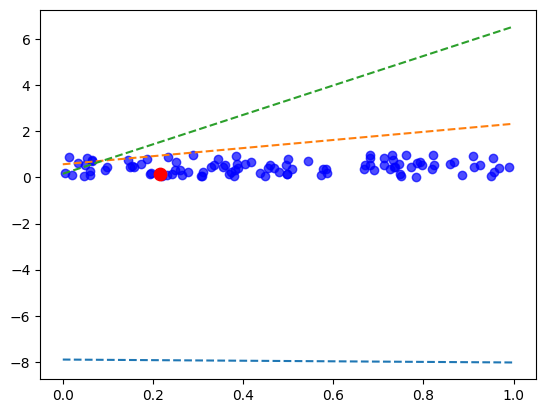

Memory Usage (bytes): 56


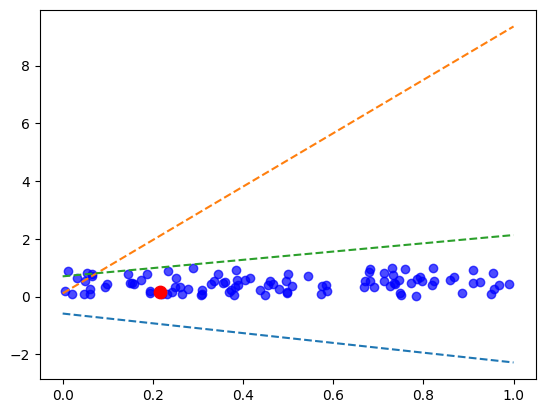

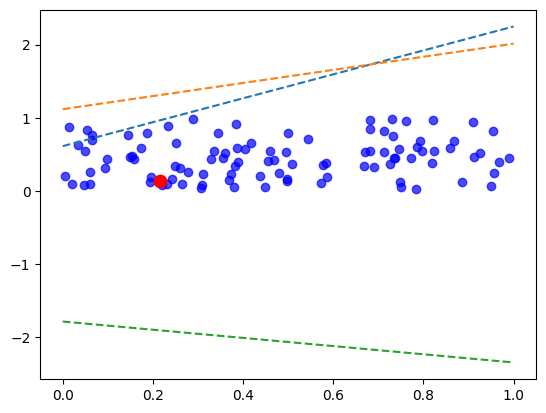

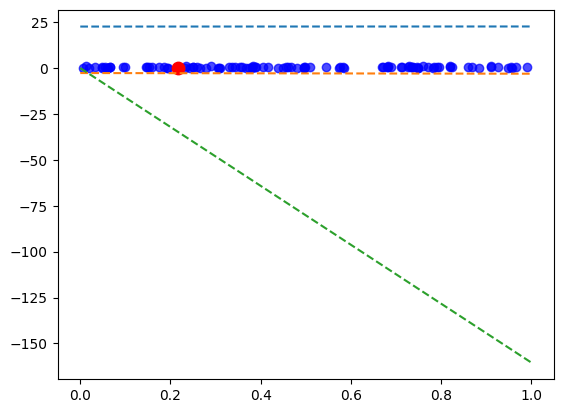

Repeated Neighbors: [[0.30655018401680345, 0.041410986360554736, 0.4260951849926251, 0.9934548668116527, 0.009829989422646013, 0.15786531103212387, 0.35656514420201113, 0.9975804641608175, 0.45086589889913176, 0.33092838881932085, 0.9749057108259889, 0.6293439344625672, 0.8341366595408937, 0.3197625445601857, 0.5299096509682465, 0.6880678483024179, 0.7949902061205986, 0.1954135230634677, 0.7419868500027474, 0.10233713052255144, 0.397923608413118, 0.7498775661330199, 0.07750767715914775, 0.8221632612521202, 0.30445202725842824, 0.3434204471848328, 0.34683744014972495, 0.9387727485145896, 0.34722378284571453, 0.3500901082729936, 0.31588640998896567, 0.8732586443958374, 0.27902015110233513, 0.5628593615852249, 0.00995316342884578, 0.9160551253351201, 0.24386451048313829, 0.29853009048132706, 0.9757951792543326, 0.23879512898990807, 0.9383719500193322, 0.9516786439561619, 0.5682074442343122, 0.5961726130274357, 0.005581974266945622, 0.8921130111131063, 0.18639925721304518, 0.79892612995796

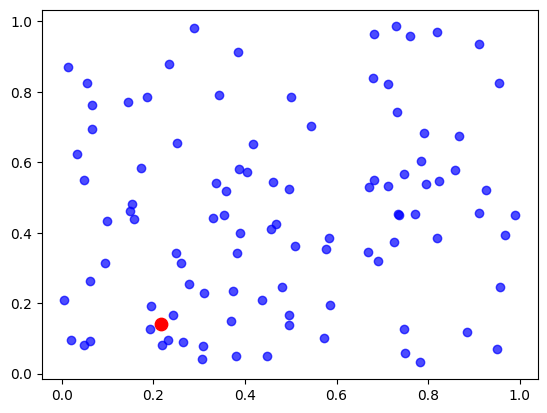

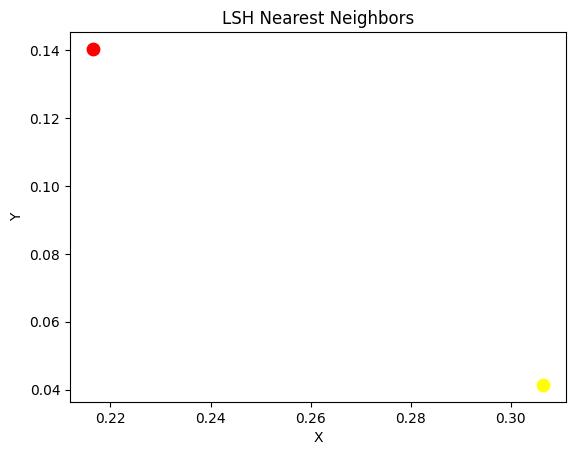

In [261]:
# Example usage:
X_train = np.random.rand(100, 50)  # Example training data
test_point = np.random.rand(1, 50)  # Example test point
hashes, hyperplanes = random_projection_lsh(X_train, P=2)  # Generate hashes and hyperplanes

import sys

# Measure memory usage
mem_usage = sys.getsizeof(lsh_nearest_neighbors(test_point, X_train, hyperplanes))

print("Memory Usage (bytes):", mem_usage)

Memory.append(mem_usage)

# Measure execution time
start_time = time.time()
potential_neighbors = lsh_nearest_neighbors(test_point, X_train, hyperplanes)
end_time = time.time()
execution_time = end_time - start_time

print("Repeated Neighbors:", potential_neighbors)
# print("Memory Usage (MB):", max(mem_usage))
print("Execution Time (seconds):", execution_time)
Time_d.append(execution_time)


# Plot training data (blue)
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
plt.show()

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
# Plot nearest neighbors (yellow)
for neighbor in potential_neighbors:
  plt.scatter(neighbor[0], neighbor[1], c='yellow', label='Nearest neighbors', marker='o', s=80)

# Add legend and labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.show()

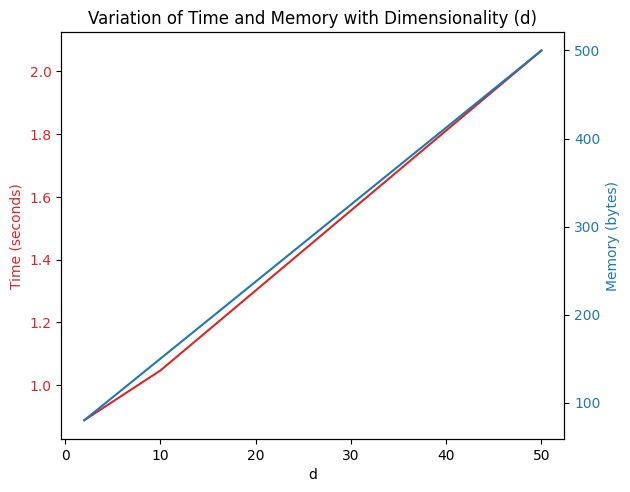

In [284]:
# Plotting
fig, ax1 = plt.subplots()
d_values = [2, 10, 50]
color = 'tab:red'
ax1.set_xlabel('d')
ax1.set_ylabel('Time (seconds)', color=color)
ax1.plot(d_values, Time_d, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Memory (bytes)', color=color)
ax2.plot(d_values, Memory, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Variation of Time and Memory with Dimensionality (d)')
plt.show()

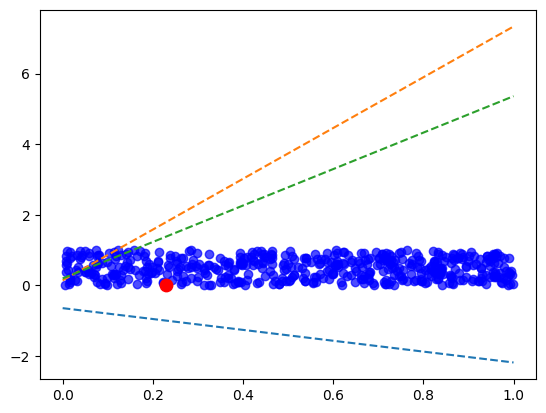

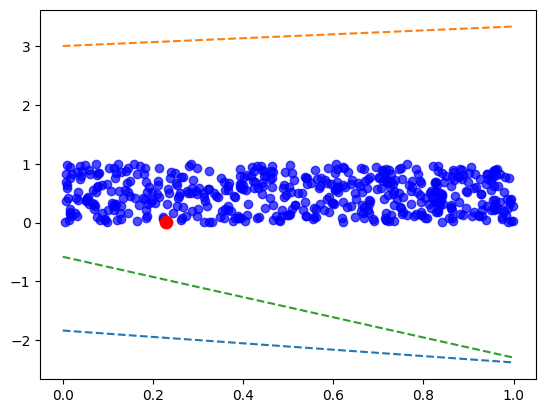

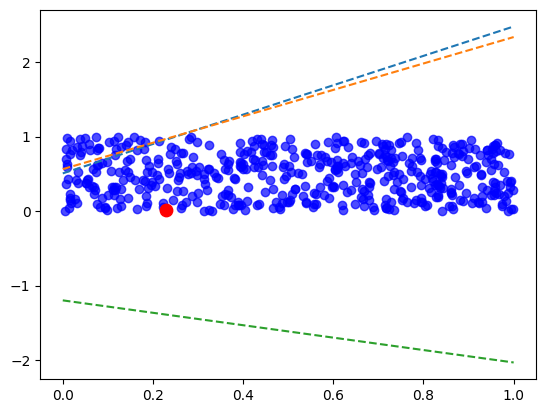

Memory Usage (bytes): 920


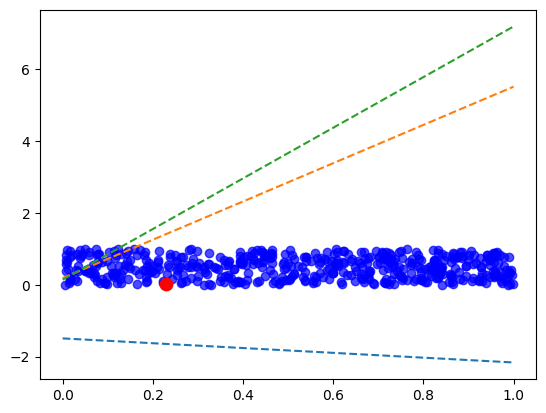

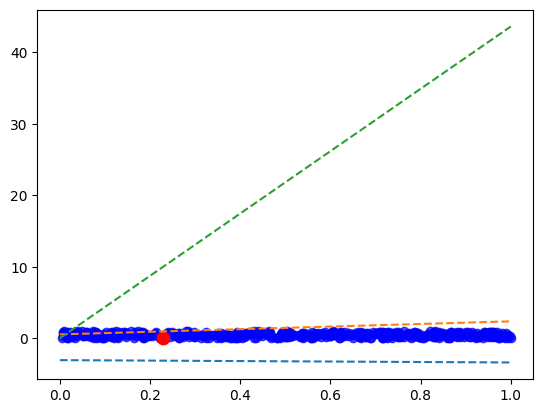

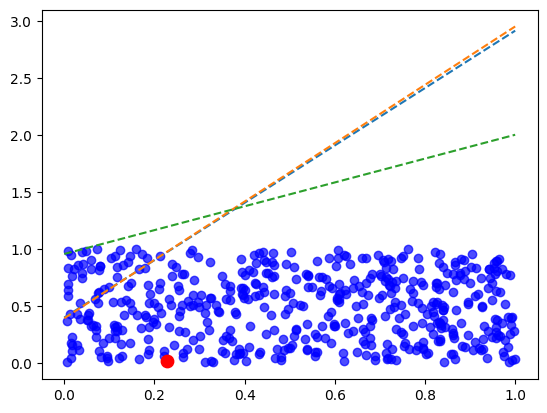

Repeated Neighbors: [[0.40934846745414766, 0.13668027124606508], [0.9297227101447508, 0.11744721639300137], [0.5612329827896874, 0.2239660695444634], [0.4962920667439855, 0.1273445456882012], [0.8611381744462554, 0.24426181427487548], [0.7416258330487928, 0.3940831917371993], [0.7367336034798786, 0.7181745281955004], [0.7102824059516298, 0.7167218661409865], [0.3249983927679052, 0.016951209449512228], [0.8345082597646856, 0.330871700093632], [0.43102476315517313, 0.07605403464737504], [0.8655351960364062, 0.03219359311047876], [0.4591910336096239, 0.41598796627871504], [0.8420437055180141, 0.4920791221066986], [0.7530829861151678, 0.14589057290718876], [0.8777726936084417, 0.7703735945277789], [0.7839558251071076, 0.14701239395756138], [0.6092215040595041, 0.5635336855629276], [0.9880873598420292, 0.24843517880152988], [0.5377821805549907, 0.34322826830063946], [0.9396732981708763, 0.6544025223764468], [0.5971012603183872, 0.3259872506346082], [0.9892869221343298, 0.7674127296039682], 

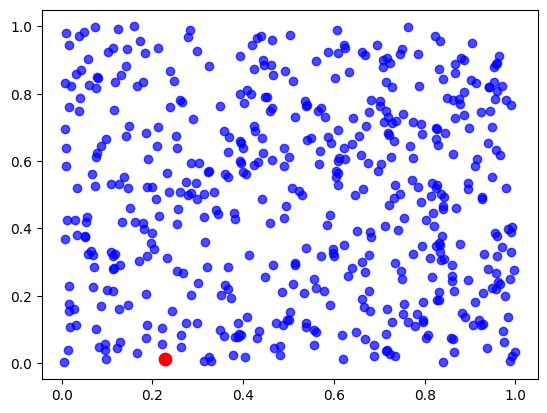

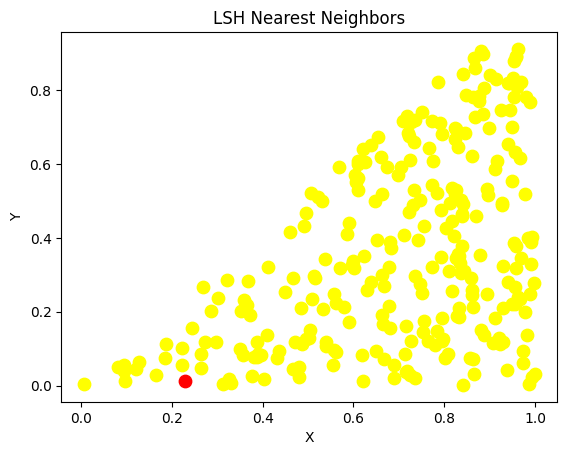

In [270]:
# Example usage:
X_train = np.random.rand(500, 2)  # Example training data
test_point = np.random.rand(1, 2)  # Example test point
hashes, hyperplanes = random_projection_lsh(X_train, P=2)  # Generate hashes and hyperplanes

import sys

# Measure memory usage
mem_usage = sys.getsizeof(lsh_nearest_neighbors(test_point, X_train, hyperplanes))

print("Memory Usage (bytes):", mem_usage)

Memory_n.append(mem_usage)

# Measure execution time
start_time = time.time()
potential_neighbors = lsh_nearest_neighbors(test_point, X_train, hyperplanes)
end_time = time.time()
execution_time = end_time - start_time

print("Repeated Neighbors:", potential_neighbors)
# print("Memory Usage (MB):", max(mem_usage))
print("Execution Time (seconds):", execution_time)
Time_n.append(execution_time)


# Plot training data (blue)
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
plt.show()

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
# Plot nearest neighbors (yellow)
for neighbor in potential_neighbors:
  plt.scatter(neighbor[0], neighbor[1], c='yellow', label='Nearest neighbors', marker='o', s=80)

# Add legend and labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.show()

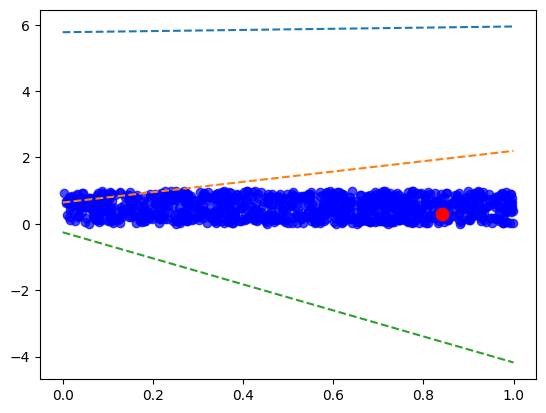

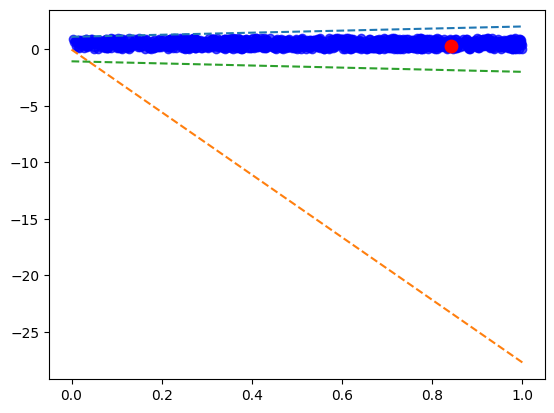

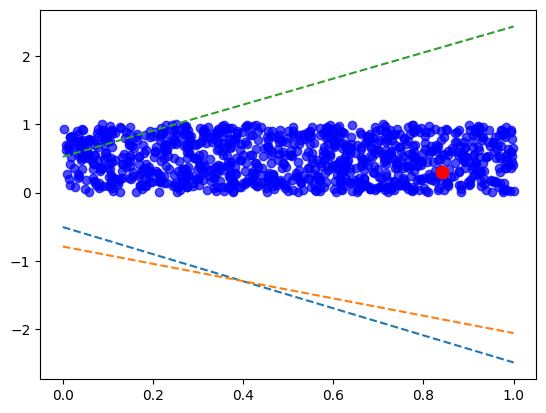

Memory Usage (bytes): 3256


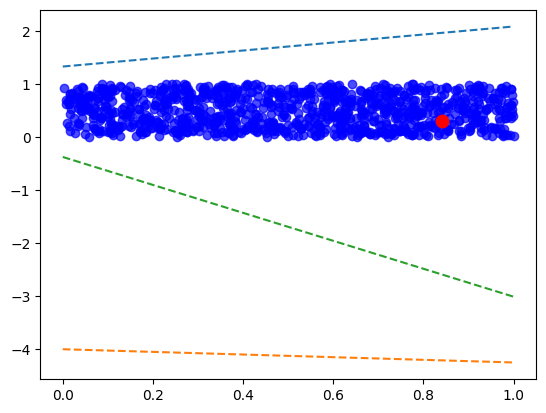

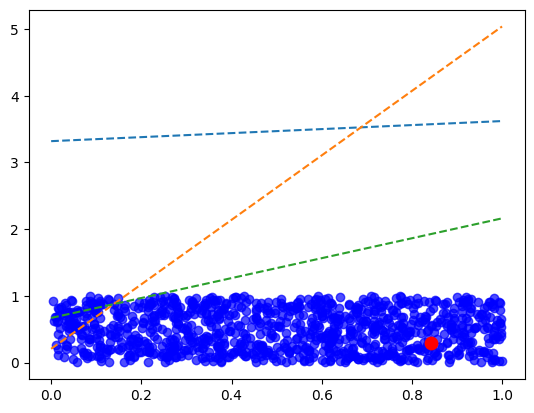

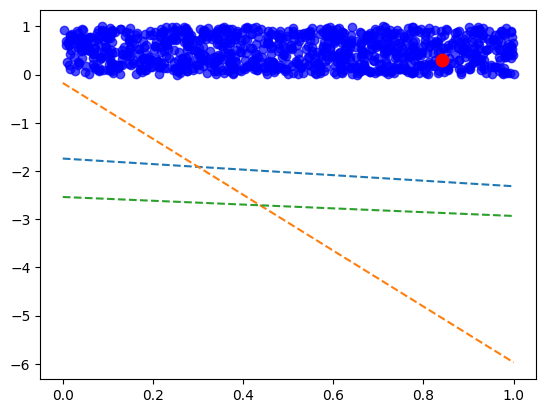

Repeated Neighbors: [[0.5734909564491208, 0.3826376571737444], [0.40367867452813966, 0.12284557133250018], [0.5431859002175154, 0.3576794201406005], [0.9968293034480348, 0.44048459837014564], [0.8148465989084984, 0.6050425281493124], [0.7405506339909083, 0.4521222791947771], [0.9001416906701537, 0.44862565470454474], [0.42214634981424404, 0.17869705337209307], [0.6275454043602056, 0.38759949244054215], [0.9727458378495171, 0.6852968938697409], [0.8709476307584448, 0.42836535317344604], [0.2727787977252337, 0.1966273802012627], [0.7173075961437249, 0.2863882531460572], [0.7405634696089396, 0.3591482916687243], [0.39867972315890066, 0.1420964606668509], [0.27603790092632663, 0.08469424547769455], [0.8536661190693835, 0.549699387149752], [0.3706888519607404, 0.25201636199281474], [0.6131996985537072, 0.4491767638401324], [0.3027070290749898, 0.10699830049716463], [0.3289582404389565, 0.1667946981924563], [0.7162288754770093, 0.24860771913674384], [0.6198302888230984, 0.32420721574496547],

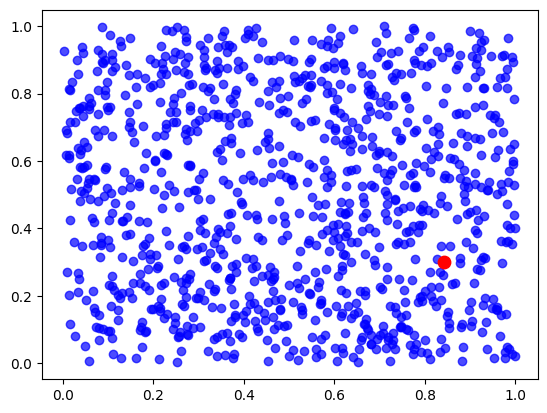

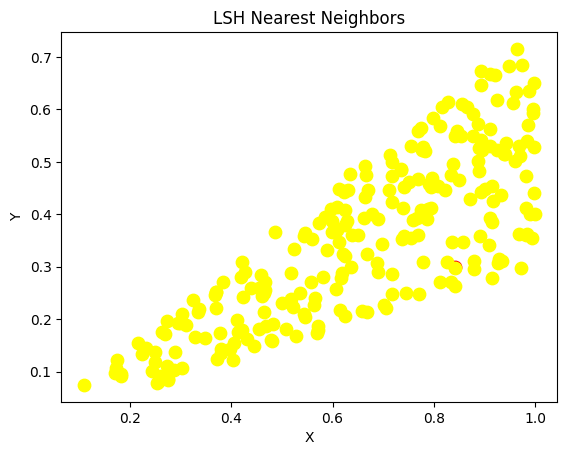

In [271]:
# Example usage:
X_train = np.random.rand(1000, 2)  # Example training data
test_point = np.random.rand(1, 2)  # Example test point
hashes, hyperplanes = random_projection_lsh(X_train, P=2)  # Generate hashes and hyperplanes

import sys

# Measure memory usage
mem_usage = sys.getsizeof(lsh_nearest_neighbors(test_point, X_train, hyperplanes))

print("Memory Usage (bytes):", mem_usage)

Memory_n.append(mem_usage)

# Measure execution time
start_time = time.time()
potential_neighbors = lsh_nearest_neighbors(test_point, X_train, hyperplanes)
end_time = time.time()
execution_time = end_time - start_time

print("Repeated Neighbors:", potential_neighbors)
# print("Memory Usage (MB):", max(mem_usage))
print("Execution Time (seconds):", execution_time)
Time_n.append(execution_time)


# Plot training data (blue)
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Data', alpha=0.7)

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
plt.show()

# Plot test point (red)
plt.scatter(test_point[0, 0], test_point[0, 1], c='red', label='Test Point', marker='o', s=80)
# Plot nearest neighbors (yellow)
for neighbor in potential_neighbors:
  plt.scatter(neighbor[0], neighbor[1], c='yellow', label='Nearest neighbors', marker='o', s=80)

# Add legend and labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Nearest Neighbors')
plt.show()

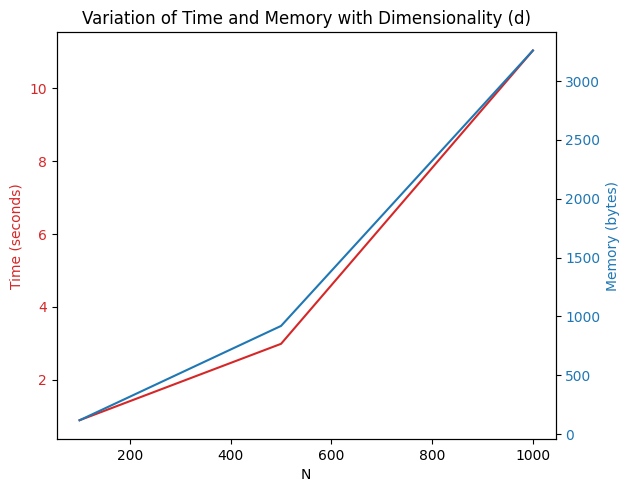

In [276]:
# Plotting
fig, ax1 = plt.subplots()
n_values = [100, 500, 1000]
color = 'tab:red'
ax1.set_xlabel('N')
ax1.set_ylabel('Time (seconds)', color=color)
ax1.plot(n_values, Time_n, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Memory (bytes)', color=color)
ax2.plot(n_values, Memory_n, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Variation of Time and Memory with Dimensionality (d)')
plt.show()